In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

In [ ]:
data_dir = '/content/drive/My Drive/ESE 546 Project/genres'

import os
path_list = []
label_list = []
for i in os.walk(data_dir, topdown=False):
    for audio in i[2]:
        if audio.find('.wav') != -1:
            path_list.append(os.path.join(i[0], audio))
            audio = audio.split('.', 1)[0]
            label_list.append(audio)

In [ ]:
path_list = np.array(path_list)
label_list = np.array(label_list)

spec_list = np.empty([1000, 1025, 1293])
mel_list = np.empty([1000, 128, 1293])
mfcc_list = np.empty([1000, 10, 1293])
chroma_list = np.empty([1000, 12, 1293])
temp_list = np.empty([1000, 384, 1293])

In [ ]:
curr = 0
invalid_idx = []
for i in tqdm(range(len(path_list))):

    try:
        curr = curr+1
        y, sr = librosa.load(path_list[i])
        spec_list[i] = librosa.amplitude_to_db(abs(librosa.stft(y)))
        mel_list[i] = librosa.power_to_db(librosa.feature.melspectrogram(y=y))
        mfcc_list[i] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc= 10)
        chroma_list[i] = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
        temp_list[i] = librosa.feature.tempogram(y=y, sr=sr)

    except Exception as e:
        invalid_idx.append(i)

 66%|██████▌   | 661/1000 [11:46<07:09,  1.27s/it]

In [ ]:
import tensorflow

val_list = list(set(range(len(path_list)))-set(invalid_idx))################store
spec_list = spec_list[val_list].astype(np.float32)
mel_list = mel_list[val_list].astype(np.float32)
mfcc_list = mfcc_list[val_list].astype(np.float32)
chroma_list = chroma_list[val_list].astype(np.float32)
temp_list = temp_list[val_list].astype(np.float32)
label_list = label_list[val_list]

genre_list = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for i in range(len(genre_list)):
    label_list[label_list == genre_list[i]] = i
label_list = np.array([int(i) for i in label_list])

final_label = tensorflow.keras.utils.to_categorical(label_list, num_classes = 10, dtype ="int32")
np.savez_compressed("/content/drive/My Drive/ESE 546 Project/RayFeatures.npz", 
                    spectrogram = spec_list, mel_spectrogram = mel_list, mfcc = mfcc_list, 
                    chromagram = chroma_list, tempogram = temp_list, target = final_label)

<ipython-input-61-68ee543e49b5>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  label_list[label_list == genre_list[i]] == i


ValueError: ignored

In [ ]:
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import ELU, PReLU, LeakyReLU
import tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [91]:
f = np.load("/content/drive/My Drive/ESE 546 Project/RayFeatures.npz")
spec = f['spectrogram']
mfcc = f['mfcc']
mel = f['mel_spectrogram']
chroma = f['chromagram']
tempo = f['tempogram']
y = f['target']
spec_train, spec_test, mfcc_train, mfcc_test, mel_train, mel_test, chroma_train, chroma_test, tempo_train, tempo_test, y_train, y_test = train_test_split(spec, mfcc, mel, chroma, tempo, y, test_size= 0.2)


In [ ]:
val_list = np.load('/content/drive/My Drive/ESE 546 Project/val_list.npy')

In [ ]:
import pandas as pd
import numpy as np
# need to add shortcut of shared drive to mydrive
data = pd.read_csv('/content/drive/My Drive/ESE 546 Project/dataset2.csv')
data['label']=pd.factorize(data['genre'])[0]
data

,Unnamed: 0,filename,genre,path,chroma_stft,chroma_cqt,chroma_cens,mels,rmse,spec_ctd,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,label
0,0,pop.00027.wav,pop,genres/pop/pop.00027.wav,0.377413,0.534632,0.270818,6.013309,0.157919,2682.713195,...,-4.227081,-1.845522,-5.907954,-1.272481,-3.783554,-2.864618,-0.935335,-1.111585,-2.721470,0
1,1,pop.00033.wav,pop,genres/pop/pop.00033.wav,0.422902,0.499411,0.260813,4.624118,0.139912,2835.059302,...,-3.025172,1.614928,1.089264,0.934386,-0.416273,-1.238210,-0.757658,-1.704667,-1.043756,0
2,2,pop.00032.wav,pop,genres/pop/pop.00032.wav,0.426649,0.515256,0.264466,2.176009,0.097891,4225.564576,...,1.255564,2.894246,-0.769548,0.220406,-1.408662,-0.760462,-0.870232,-1.539206,1.067266,0
3,3,pop.00026.wav,pop,genres/pop/pop.00026.wav,0.335030,0.489829,0.252922,9.995846,0.195668,2526.130442,...,-4.921416,-0.030956,-3.046364,-0.158968,-2.381000,0.723444,0.682856,1.968364,0.803763,0
4,4,pop.00030.wav,pop,genres/pop/pop.00030.wav,0.357699,0.443657,0.255050,9.731588,0.203106,3070.645171,...,-1.057464,2.519505,1.247287,1.752371,-3.442980,0.394540,-0.852501,0.924300,1.660296,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,jazz.00018.wav,jazz,genres/jazz/jazz.00018.wav,0.353409,0.451491,0.250173,0.664446,0.052225,1992.940890,...,9.585426,-5.195148,7.830173,-3.869452,12.349874,-1.117487,-0.777686,-2.981298,0.358095,9
996,996,jazz.00032.wav,jazz,genres/jazz/jazz.00032.wav,0.280777,0.427040,0.247782,0.513812,0.040503,1522.348449,...,0.305342,-8.618950,2.593334,-6.969912,-2.922460,-4.650738,-3.246634,-4.451148,-3.968114,9
997,997,jazz.00026.wav,jazz,genres/jazz/jazz.00026.wav,0.201862,0.264902,0.183821,0.307372,0.031924,1367.411537,...,0.894059,-1.463813,7.720704,1.254868,6.035240,5.243723,2.428200,7.604022,9.802248,9
998,998,jazz.00027.wav,jazz,genres/jazz/jazz.00027.wav,0.325289,0.446573,0.258347,0.417382,0.040597,1769.401599,...,11.932401,-3.427911,7.197285,-8.854767,4.973091,-4.053073,-0.118045,-0.819828,-0.602167,9


In [ ]:
X_svm = (data[data.columns[4:len(data.columns)-2]].to_numpy())[val_list]
len(X_svm)

944

In [92]:
spec_temp, spec_test, mfcc_temp, mfcc_test, mel_temp, mel_test, chroma_temp, chroma_test, tempo_temp, tempo_test, svm_temp, svm_test, y_temp, y_test = train_test_split(spec, mfcc, mel, chroma, tempo, X_svm, y, test_size= 0.2)
spec_train, spec_val, mfcc_train, mfcc_val, mel_train, mel_val, chroma_train, chroma_val, tempo_train, tempo_val, svm_train, svm_val, y_train, y_val = train_test_split(spec_temp, mfcc_temp, mel_temp, chroma_temp, tempo_temp, svm_temp, y_temp, test_size= 0.2)

svm accuracy: 0.5496688741721855


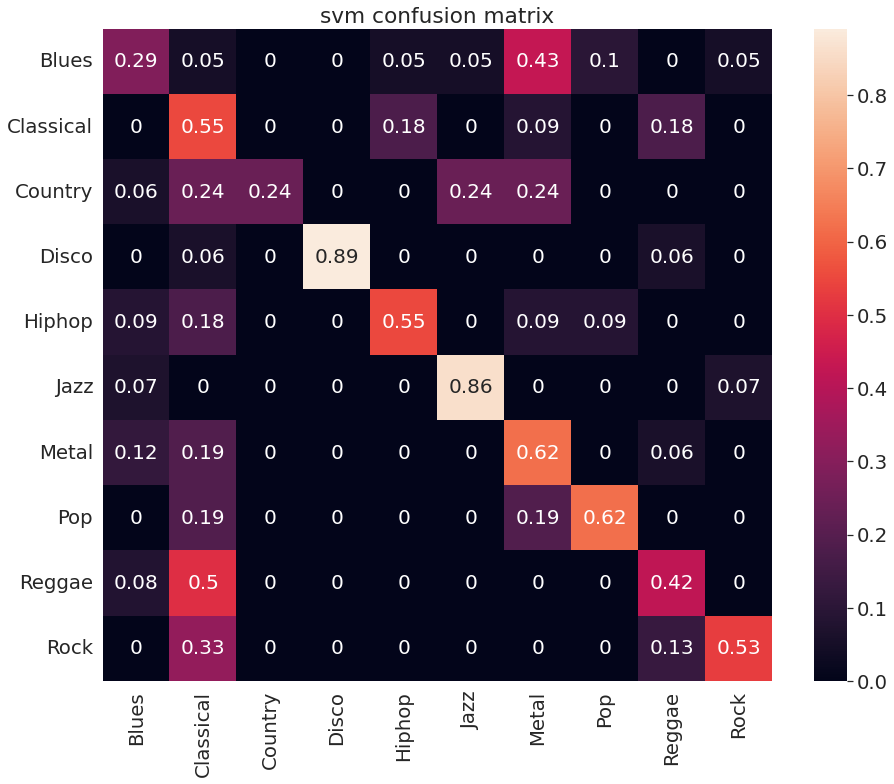

In [138]:
# svm

from sklearn import svm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(svm_train)
X_trainsvm = scaler.transform(svm_train)
scaler = StandardScaler()
scaler.fit(svm_val)
X_valsvm = scaler.transform(svm_val)
from sklearn import metrics
clf = svm.SVC(kernel='poly')
clf.fit(X_trainsvm, np.argmax(y_train, axis= -1))
y_pred_svm = clf.predict(X_valsvm)
print("svm accuracy:",metrics.accuracy_score(np.argmax(y_val, axis= -1), y_pred_svm))
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(np.argmax(y_val, axis= -1), y_pred_svm, normalize= 'true'),2)
cm_svm_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('svm confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_svm_df, annot=True, annot_kws={"size": 20})

In [145]:
# spectrogram

maximum1 = np.amax(spec_train)
spec_train = (spec_train/np.amax(maximum1)).astype(np.float32)
N, row, col = spec_train.shape
spec_train = spec_train.reshape((N, row, col, 1))
spec_val = (spec_val/np.amax(maximum1)).astype(np.float32)
N, row, col = spec_val.shape
spec_val = spec_val.reshape((N, row, col, 1))
spec_test = (spec_test/np.amax(maximum1)).astype(np.float32)
N, row, col = spec_test.shape
spec_test = spec_test.reshape((N, row, col, 1))

In [144]:
spec_model = Sequential()
spec_model.add(Conv2D(10, (3,3), activation= 'relu', input_shape= spec_train[0].shape, padding= 'same'))
spec_model.add(MaxPooling2D((3,3), padding= 'same'))
spec_model.add(Conv2D(20, (3,3), activation= 'relu', padding= 'same'))
spec_model.add(MaxPooling2D((3,3), padding= 'same'))
spec_model.add(Conv2D(40, (3,3), activation= 'relu', padding= 'same'))
spec_model.add(MaxPooling2D((3,3), padding= 'same'))
spec_model.add(Conv2D(70, (3,3), activation= 'relu', padding= 'same'))
spec_model.add(MaxPooling2D((3,3), padding= 'same'))
spec_model.add(Conv2D(100, (3,3), activation= 'relu', padding= 'same'))
spec_model.add(MaxPooling2D((3,3), padding= 'same'))
spec_model.add(Flatten())
spec_model.add(Dense(100, activation= 'relu'))
spec_model.add(Dense(50, activation= 'relu'))
spec_model.add(Dense(10, activation= 'softmax'))

spec_model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
spec_model.summary()
spec_model.fit(spec_train, y_train, epochs= 100, batch_size= 32, verbose= 1)

ValueError: ignored

In [73]:
spec_model.save('/content/drive/My Drive/ESE 546 Project/spec_model.h5')

In [146]:
spec_model = load_model('/content/drive/My Drive/ESE 546 Project/spec_model.h5')

19/19 [==============================] - 1s 59ms/step
Train accuracy is 0.9983443708609272
5/5 [==============================] - 0s 56ms/step
Validation accuracy is 0.6622516556291391


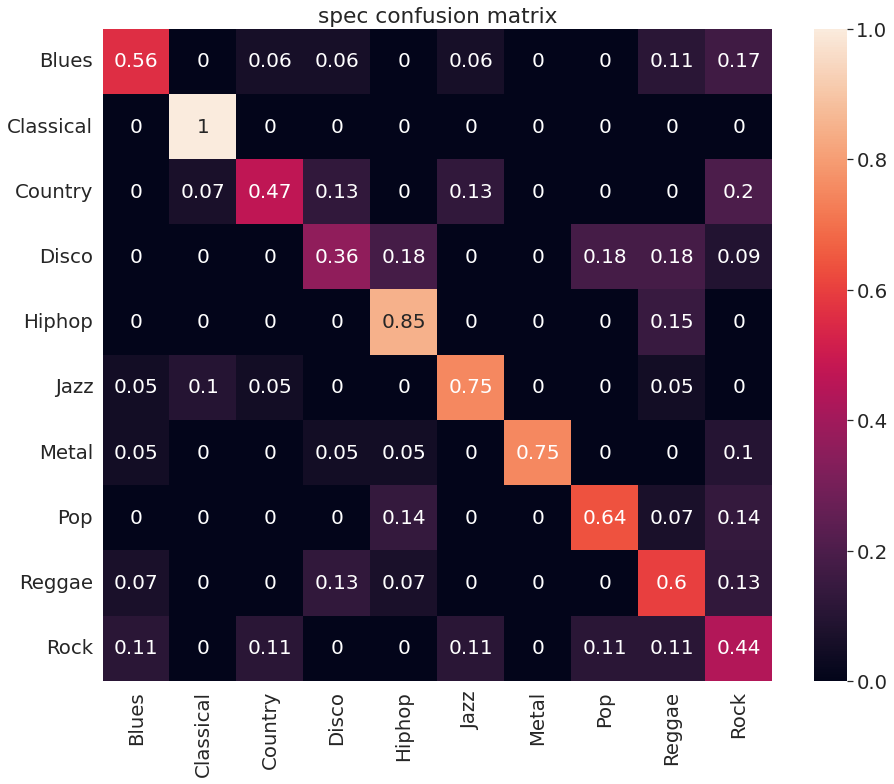

In [80]:
y_pred = spec_model.predict(spec_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Train accuracy is "+str(acc))

y_pred = spec_model.predict(spec_val)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_val, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Validation accuracy is "+str(acc))

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_spec_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('spec confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_spec_df, annot=True, annot_kws={"size": 20})

In [148]:
train_mfcc = np.empty((mfcc_train.shape[0], 120, 600))
val_mfcc = np.empty((mfcc_val.shape[0], 120, 600))
test_mfcc = np.empty((mfcc_test.shape[0], 120, 600))

for i in range(mfcc_train.shape[0]) :
    curr = mfcc_train[i]
    curr = cv2.resize(curr, (600, 120))
    train_mfcc[i] = curr

mfcc_train = train_mfcc
mfcc_train = mfcc_train.astype(np.float32)
N, row, col = mfcc_train.shape
mfcc_train = mfcc_train.reshape((N, row, col, 1))
mean_train = np.mean(mfcc_train)
std_train = np.std(mfcc_train)
mfcc_train = (mfcc_train - mean_train)/ std_train

for i in range(mfcc_val.shape[0]) :
    curr = mfcc_val[i]
    curr = cv2.resize(curr, (600, 120))
    val_mfcc[i] = curr

mfcc_val = val_mfcc
mfcc_val = mfcc_val.astype(np.float32)
N, row, col = mfcc_val.shape
mfcc_val = mfcc_val.reshape((N, row, col, 1))
mfcc_val = (mfcc_val - mean_train)/ std_train

for i in range(mfcc_test.shape[0]) :
    curr = mfcc_test[i]
    curr = cv2.resize(curr, (600, 120))
    test_mfcc[i] = curr

mfcc_test = test_mfcc
mfcc_test = mfcc_test.astype(np.float32)
N, row, col = mfcc_test.shape
mfcc_test = mfcc_test.reshape((N, row, col, 1))
mfcc_test = (mfcc_test - mean_train)/ std_train

In [82]:
mfcc_model = Sequential()
mfcc_model.add(Conv2D(16, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
mfcc_model.add(BatchNormalization())
mfcc_model.add(MaxPooling2D((4,6), padding= 'same'))
mfcc_model.add(Conv2D(32, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
mfcc_model.add(BatchNormalization())
mfcc_model.add(MaxPooling2D((4,6), padding= 'same'))
mfcc_model.add(Conv2D(64, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
mfcc_model.add(BatchNormalization())
mfcc_model.add(MaxPooling2D((4,6), padding= 'same'))
mfcc_model.add(Conv2D(64, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
mfcc_model.add(BatchNormalization())
mfcc_model.add(MaxPooling2D((4,6), padding= 'same'))
mfcc_model.add(Flatten())
mfcc_model.add(Dense(256, activation= 'tanh'))
mfcc_model.add(Dense(64, activation= 'tanh'))
mfcc_model.add(Dense(10, activation= 'softmax'))

mfcc_model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
mfcc_model.summary()
mfcc_model.fit(mfcc_train, y_train, epochs= 100, batch_size= 32, verbose= 1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 120, 600, 16)      160       
                                                                 
 batch_normalization_21 (Bat  (None, 120, 600, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 30, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 30, 100, 32)       4640      
                                                                 
 batch_normalization_22 (Bat  (None, 30, 100, 32)      128       
 chNormalization)                                                
                                                     

19/19 [==============================] - 0s 5ms/step
Train accuracy is 0.9983443708609272
5/5 [==============================] - 0s 8ms/step
Validation accuracy is 0.6821192052980133


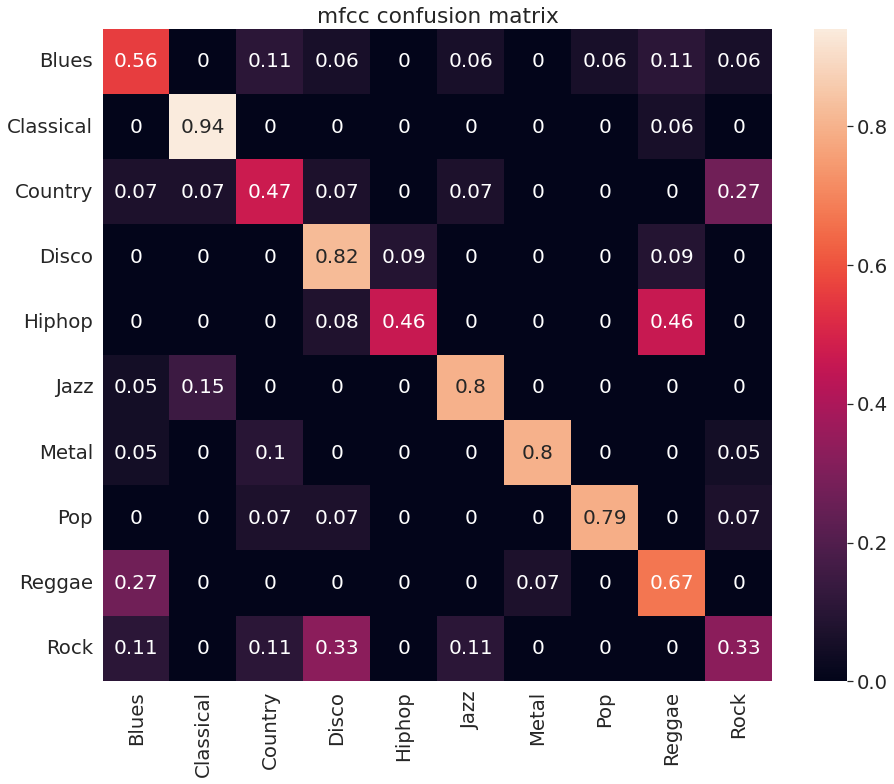

In [83]:
y_pred = mfcc_model.predict(mfcc_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Train accuracy is "+str(acc))

y_pred = mfcc_model.predict(mfcc_val)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_val, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Validation accuracy is "+str(acc))

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_mfcc_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('mfcc confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_mfcc_df, annot=True, annot_kws={"size": 20})

In [84]:
mfcc_model.save('/content/drive/My Drive/ESE 546 Project/mfcc_model.h5')

In [149]:
mfcc_model = load_model('/content/drive/My Drive/ESE 546 Project/mfcc_model.h5')

In [93]:
# Mel-Spectrogram

maximum = np.amax(mel_train)
mel_train = (mel_train/np.amax(maximum)).astype(np.float32)
N, row, col = mel_train.shape
mel_train = mel_train.reshape((N, row, col, 1))
mel_val = (mel_val/np.amax(maximum)).astype(np.float32)
N, row, col = mel_val.shape
mel_val = mel_val.reshape((N, row, col, 1))
mel_test = (mel_test/np.amax(maximum)).astype(np.float32)
N, row, col = mel_test.shape
mel_test = mel_test.reshape((N, row, col, 1))

In [96]:
mel_model = Sequential()
mel_model.add(Conv2D(10, (3,3), activation= 'relu', input_shape= mel_train[0].shape, padding= 'same'))
mel_model.add(MaxPooling2D((4,4), padding= 'same'))
mel_model.add(Conv2D(20, (3,3), activation= 'relu', padding= 'same'))
mel_model.add(MaxPooling2D((4,4), padding= 'same'))
mel_model.add(Conv2D(40, (3,3), activation= 'relu', padding= 'same'))
mel_model.add(MaxPooling2D((4,4), padding= 'same'))
mel_model.add(Conv2D(70, (3,3), activation= 'relu', padding= 'same'))
mel_model.add(MaxPooling2D((4,4), padding= 'same'))
mel_model.add(Conv2D(100, (3,3), activation= 'relu', padding= 'same'))
mel_model.add(MaxPooling2D((4,4), padding= 'same'))
mel_model.add(Flatten())
mel_model.add(Dense(70, activation= 'relu'))
mel_model.add(Dense(30, activation= 'relu'))
mel_model.add(Dense(10, activation= 'softmax'))

mel_model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
mel_model.summary()
mel_model.fit(mel_train, y_train, epochs= 100, batch_size= 32, verbose= 1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 128, 1293, 10)     100       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 32, 324, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 32, 324, 20)       1820      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 8, 81, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 8, 81, 40)         7240      
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 2, 21, 40)      

In [98]:
mel_model.save('/content/drive/My Drive/ESE 546 Project/mel_model.h5')

In [99]:
mel_model = load_model('/content/drive/My Drive/ESE 546 Project/mel_model.h5')

19/19 [==============================] - 0s 9ms/step
Train accuracy is 1.0
5/5 [==============================] - 0s 22ms/step
Validation accuracy is 0.6754966887417219


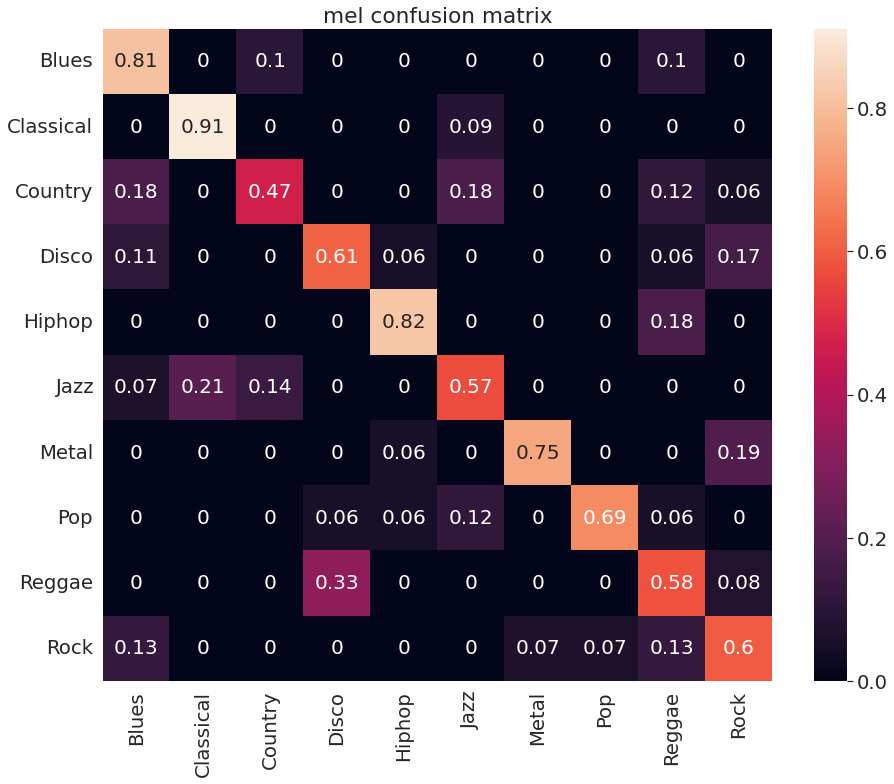

In [97]:
y_pred = mel_model.predict(mel_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Train accuracy is "+str(acc))

y_pred = mel_model.predict(mel_val)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_val, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Validation accuracy is "+str(acc))

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_mel_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('mel confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_mel_df, annot=True, annot_kws={"size": 20})

In [101]:
# tempogram

maximum = np.amax(tempo_train)
tempo_train = (tempo_train/np.amax(maximum)).astype(np.float32)
N, row, col = tempo_train.shape
tempo_train = tempo_train.reshape((N, row, col, 1))
tempo_val = (tempo_val/np.amax(maximum)).astype(np.float32)
N, row, col = tempo_val.shape
tempo_val = tempo_val.reshape((N, row, col, 1))
tempo_test = (tempo_test/np.amax(maximum)).astype(np.float32)
N, row, col = tempo_test.shape
tempo_test = tempo_test.reshape((N, row, col, 1))

In [110]:
tempo_model = Sequential()
tempo_model.add(Conv2D(10, (2,2), activation= 'relu', input_shape= tempo_train[0].shape, padding= 'same'))
tempo_model.add(MaxPooling2D((2,2), padding= 'same'))
tempo_model.add(Conv2D(20, (2,2), activation= 'relu', padding= 'same'))
tempo_model.add(MaxPooling2D((2,2), padding= 'same'))
tempo_model.add(Conv2D(40, (3,3), activation= 'relu', padding= 'same'))
tempo_model.add(MaxPooling2D((4,4), padding= 'same'))
tempo_model.add(Conv2D(70, (2,2), activation= 'relu', padding= 'same'))
tempo_model.add(MaxPooling2D((2,2), padding= 'same'))
tempo_model.add(Conv2D(100, (2,2), activation= 'relu', padding= 'same'))
tempo_model.add(MaxPooling2D((2,2), padding= 'same'))
tempo_model.add(Flatten())
tempo_model.add(Dense(100, activation= 'relu'))
tempo_model.add(Dense(50, activation= 'relu'))
tempo_model.add(Dense(10, activation= 'softmax'))

tempo_model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
tempo_model.summary()
tempo_model.fit(tempo_train, y_train, epochs= 100, batch_size= 32, verbose= 1)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 384, 1293, 10)     50        
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 192, 647, 10)     0         
 ng2D)                                                           
                                                                 
 conv2d_111 (Conv2D)         (None, 192, 647, 20)      820       
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 96, 324, 20)      0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 96, 324, 40)       7240      
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 24, 81, 40)     

In [112]:
tempo_model.save('/content/drive/My Drive/ESE 546 Project/tempo_model.h5')

In [113]:
tempo_model = load_model('/content/drive/My Drive/ESE 546 Project/tempo_model.h5')

19/19 [==============================] - 1s 24ms/step
Train accuracy is 1.0
5/5 [==============================] - 0s 34ms/step
Validation accuracy is 0.3708609271523179


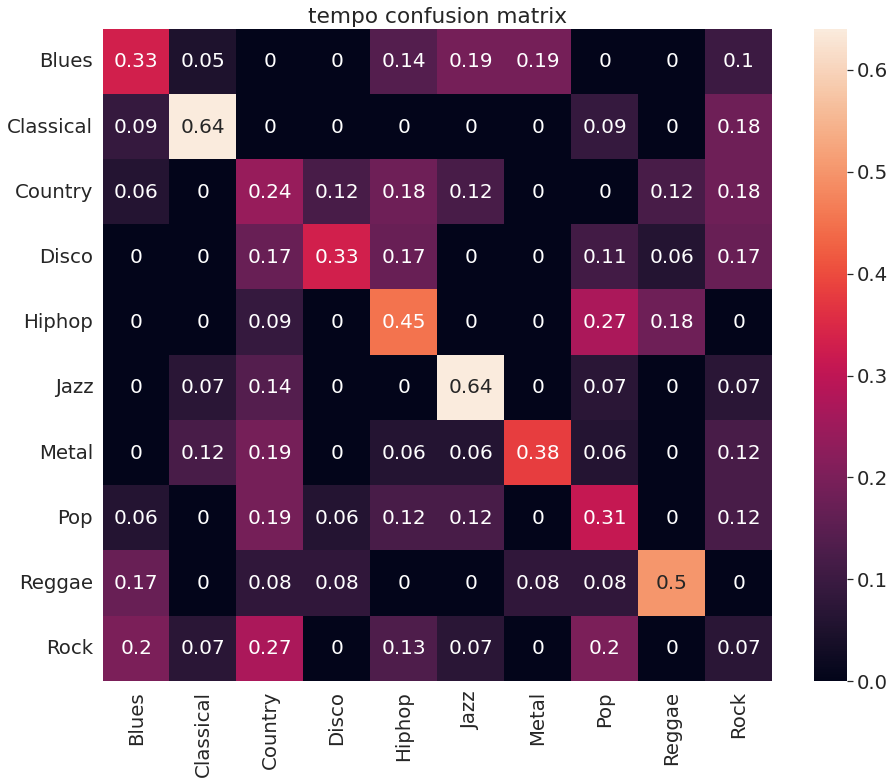

In [111]:
y_pred = tempo_model.predict(tempo_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Train accuracy is "+str(acc))

y_pred = tempo_model.predict(tempo_val)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_val, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Validation accuracy is "+str(acc))

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_tempo_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('tempo confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_tempo_df, annot=True, annot_kws={"size": 20})

In [116]:
# chromagram

maximum = np.amax(chroma_train)
chroma_train = (chroma_train/np.amax(maximum)).astype(np.float32)
N, row, col = chroma_train.shape
chroma_train = chroma_train.reshape((N, row, col, 1))
chroma_val = (chroma_val/np.amax(maximum)).astype(np.float32)
N, row, col = chroma_val.shape
chroma_val = chroma_val.reshape((N, row, col, 1))
chroma_test = (chroma_test/np.amax(maximum)).astype(np.float32)
N, row, col = chroma_test.shape
chroma_test = chroma_test.reshape((N, row, col, 1))

ValueError: ignored

In [128]:
chroma_model = Sequential()
chroma_model.add(Conv2D(10, (3,3), activation= 'relu', input_shape= chroma_train[0].shape, padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Conv2D(20, (3,3), activation= 'relu', padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Conv2D(40, (3,3), activation= 'relu', padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Conv2D(70, (3,3), activation= 'relu', padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Conv2D(100, (3,3), activation= 'relu', padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Conv2D(200, (3,3), activation= 'relu', padding= 'same'))
chroma_model.add(MaxPooling2D((4,4), padding= 'same'))
chroma_model.add(Flatten())
chroma_model.add(Dense(150, activation= 'relu'))
chroma_model.add(Dense(50, activation= 'relu'))
chroma_model.add(Dense(10, activation= 'softmax'))

chroma_model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
chroma_model.summary()
chroma_model.fit(chroma_train, y_train, epochs= 200, batch_size= 32, verbose= 1)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_154 (Conv2D)         (None, 12, 1293, 10)      100       
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 3, 324, 10)       0         
 ng2D)                                                           
                                                                 
 conv2d_155 (Conv2D)         (None, 3, 324, 20)        1820      
                                                                 
 max_pooling2d_154 (MaxPooli  (None, 1, 81, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_156 (Conv2D)         (None, 1, 81, 40)         7240      
                                                                 
 max_pooling2d_155 (MaxPooli  (None, 1, 21, 40)      

In [130]:
chroma_model.save('/content/drive/My Drive/ESE 546 Project/chroma_model.h5')

In [131]:
chroma_model = load_model('/content/drive/My Drive/ESE 546 Project/chroma_model.h5')

19/19 [==============================] - 0s 3ms/step
Train accuracy is 1.0
5/5 [==============================] - 0s 3ms/step
Validation accuracy is 0.37748344370860926


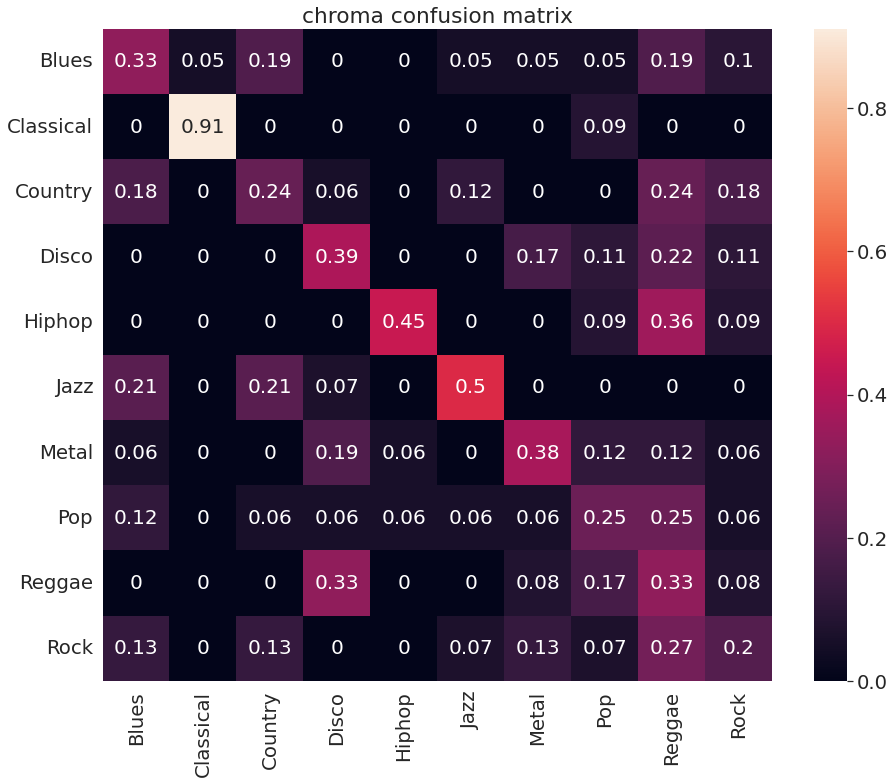

In [129]:
y_pred = chroma_model.predict(chroma_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Train accuracy is "+str(acc))

y_pred = chroma_model.predict(chroma_val)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_val, axis= -1)
acc = (len(y_pred) - np.count_nonzero(y_pred - y_true))/ len(y_pred)
print("Validation accuracy is "+str(acc))

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_chroma_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('chroma confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_chroma_df, annot=True, annot_kws={"size": 20})

5/5 [==============================] - 0s 3ms/step
Combined validation accuracy is 0.7748344370860927


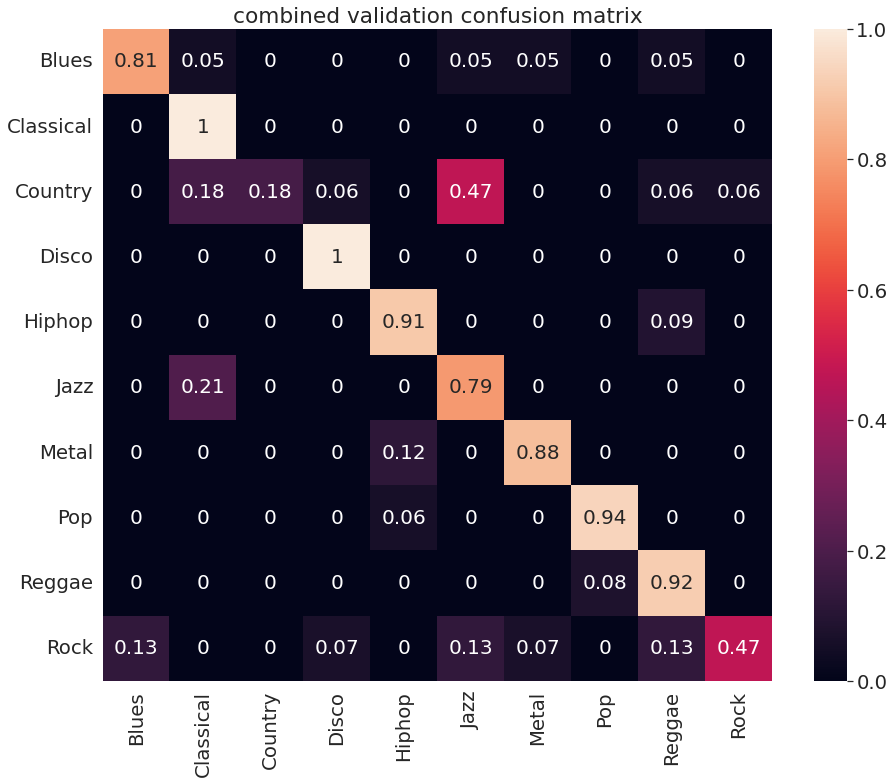

In [156]:
# combine
svm_acc = np.diag((cm_svm_df).to_numpy())
spec_acc = np.diag((cm_spec_df).to_numpy())
mfcc_acc = np.diag((cm_mfcc_df).to_numpy())
mel_acc = np.diag((cm_mel_df).to_numpy())
tempo_acc = np.diag((cm_tempo_df).to_numpy())
chroma_acc = np.diag((cm_chroma_df).to_numpy())
from sklearn import svm
from sklearn.preprocessing import StandardScaler
spec_pred = np.argmax(spec_model.predict(spec_val), axis= -1)
mfcc_pred = np.argmax(mfcc_model.predict(mfcc_val), axis= -1)
mel_pred = np.argmax(mel_model.predict(mel_val), axis= -1)
tempo_pred = np.argmax(tempo_model.predict(tempo_val), axis= -1)
chroma_pred = np.argmax(chroma_model.predict(chroma_val), axis= -1)
pred = [y_pred_svm, spec_pred, mfcc_pred, mel_pred, tempo_pred, chroma_pred]
final_val_pred = []
for i in range(len(y_pred_svm)):
    temp = [svm_acc[int(y_pred_svm[i])], spec_acc[int(spec_pred[i])], mfcc_acc[int(mfcc_pred[i])],
            mel_acc[int(mel_pred[i])], tempo_acc[int(tempo_pred[i])], chroma_acc[int(chroma_pred[i])]]
    final_val_pred.append(pred[np.argmax(temp, axis= -1)][i])
y_true = np.argmax(y_val, axis= -1)
acc = (len(final_val_pred) - np.count_nonzero(final_val_pred - y_true))/ len(final_val_pred)
print("Combined validation accuracy is "+str(acc))
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, final_val_pred, normalize= 'true'),2)
cm_val_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('combined validation confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_val_df, annot=True, annot_kws={"size": 20})

In [159]:
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
y_true = np.argmax(y_test, axis= -1)
from sklearn import svm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(svm_train)
X_trainsvm = scaler.transform(svm_train)
scaler = StandardScaler()
scaler.fit(svm_test)
X_testsvm = scaler.transform(svm_test)
from sklearn import metrics
clf = svm.SVC(kernel='poly')
clf.fit(X_trainsvm, np.argmax(y_train, axis= -1))
y_pred_svm = clf.predict(X_testsvm)
cm = np.round(confusion_matrix(y_true, y_pred_svm, normalize= 'true'),2)
cm_svm_df = pd.DataFrame(cm, columns= class_names, index= class_names)

y_pred = spec_model.predict(spec_test)
y_pred = np.argmax(y_pred, axis= -1)
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_spec_df = pd.DataFrame(cm, columns= class_names, index= class_names)

y_pred = mfcc_model.predict(mfcc_test)
y_pred = np.argmax(y_pred, axis= -1)
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_mfcc_df = pd.DataFrame(cm, columns= class_names, index= class_names)

y_pred = mel_model.predict(mel_test)
y_pred = np.argmax(y_pred, axis= -1)
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_mel_df = pd.DataFrame(cm, columns= class_names, index= class_names)

y_pred = tempo_model.predict(tempo_test)
y_pred = np.argmax(y_pred, axis= -1)
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_tempo_df = pd.DataFrame(cm, columns= class_names, index= class_names)

y_pred = chroma_model.predict(chroma_test)
y_pred = np.argmax(y_pred, axis= -1)
cm = np.round(confusion_matrix(y_true, y_pred, normalize= 'true'),2)
cm_chroma_df = pd.DataFrame(cm, columns= class_names, index= class_names)

6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step
Combined test accuracy is 0.7724867724867724


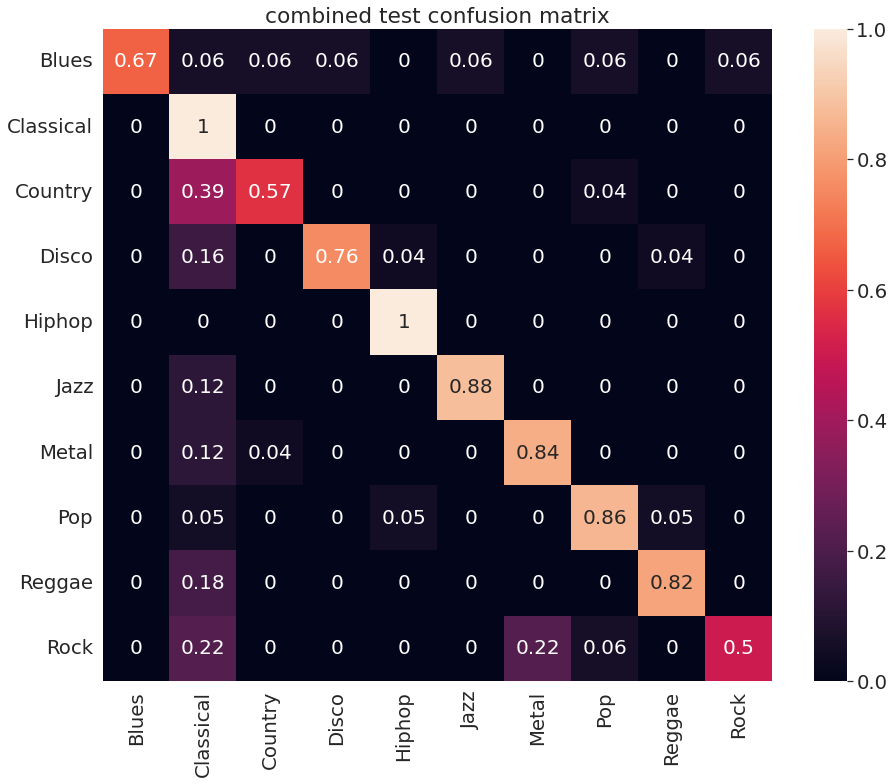

In [160]:
# combine
from sklearn import svm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(svm_train)
X_trainsvm = scaler.transform(svm_train)
scaler = StandardScaler()
scaler.fit(svm_test)
X_testsvm = scaler.transform(svm_test)
from sklearn import metrics
clf = svm.SVC(kernel='poly')
clf.fit(X_trainsvm, np.argmax(y_train, axis= -1))
y_pred_svm = clf.predict(X_testsvm)
svm_acc = np.diag((cm_svm_df).to_numpy())
spec_acc = np.diag((cm_spec_df).to_numpy())
mfcc_acc = np.diag((cm_mfcc_df).to_numpy())
mel_acc = np.diag((cm_mel_df).to_numpy())
tempo_acc = np.diag((cm_tempo_df).to_numpy())
chroma_acc = np.diag((cm_chroma_df).to_numpy())
from sklearn import svm
from sklearn.preprocessing import StandardScaler
spec_pred = np.argmax(spec_model.predict(spec_test), axis= -1)
mfcc_pred = np.argmax(mfcc_model.predict(mfcc_test), axis= -1)
mel_pred = np.argmax(mel_model.predict(mel_test), axis= -1)
tempo_pred = np.argmax(tempo_model.predict(tempo_test), axis= -1)
chroma_pred = np.argmax(chroma_model.predict(chroma_test), axis= -1)
pred = [y_pred_svm, spec_pred, mfcc_pred, mel_pred, tempo_pred, chroma_pred]
final_test_pred = []
for i in range(len(y_pred_svm)):
    temp = [svm_acc[int(y_pred_svm[i])], spec_acc[int(spec_pred[i])], mfcc_acc[int(mfcc_pred[i])],
            mel_acc[int(mel_pred[i])], tempo_acc[int(tempo_pred[i])], chroma_acc[int(chroma_pred[i])]]
    final_test_pred.append(pred[np.argmax(temp, axis= -1)][i])
y_true = np.argmax(y_test, axis= -1)
acc = (len(final_test_pred) - np.count_nonzero(final_test_pred - y_true))/ len(final_test_pred)
print("Combined test accuracy is "+str(acc))
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
cm = np.round(confusion_matrix(y_true, final_test_pred, normalize= 'true'),2)
cm_test_df = pd.DataFrame(cm, columns= class_names, index= class_names)
plt.figure(figsize = (15,12))
plt.title('combined test confusion matrix')
sn.set(font_scale=1.8)
sn.heatmap(cm_test_df, annot=True, annot_kws={"size": 20})